In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
from scipy import linalg
import matplotlib as mpl
import itertools

import matplotlib.cm as cm

from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans

np.random.seed(42)

# Utilities

In [30]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

def load_data(ds):
    df = pd.read_csv("data/" + ds)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X, y = X.to_numpy(), y.to_numpy()
    return X, y

def load_data_df(ds):
    df = pd.read_csv("data/" + ds)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    # X, y = X.to_numpy(), y.to_numpy()
    return X, y
    
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()
    
def generate_silhoutte_score_plot(X, k, model):
    n_clusters=np.arange(2, k)
    sils=[]
    sils_err=[]
    iterations=k
    for n in n_clusters:
        tmp_sil=[]
        for _ in range(iterations):
            clf=model(n).fit(X) 
            labels=clf.predict(X)
            sil=metrics.silhouette_score(X, labels, metric='euclidean')
            tmp_sil.append(sil)
        val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
        err=np.std(tmp_sil)
        sils.append(val)
        sils_err.append(err)
    plt.errorbar(n_clusters, sils, yerr=sils_err)
    plt.title("Silhouette Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("Score")

def generate_distance_bw_gmms_plots(X, n):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    n_clusters=np.arange(2, n)
    iterations=n
    results=[]
    res_sigs=[]
    for n in n_clusters:
        dist=[]

        for iteration in range(iterations):
            train, test=train_test_split(X, test_size=0.5)

            gmm_train=GaussianMixture(n, n_init=2).fit(train) 
            gmm_test=GaussianMixture(n, n_init=2).fit(test) 
            dist.append(gmm_js(gmm_train, gmm_test))
        selec=SelBest(np.array(dist), int(iterations/5))
        result=np.mean(selec)
        res_sig=np.std(selec)
        results.append(result)
        res_sigs.append(res_sig)


    plt.errorbar(n_clusters, results, yerr=res_sigs)
    plt.title("Distance between Train and Test GMMs", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Distance")
    plt.show()

def generate_bic_plot(X, n):
    n_clusters=np.arange(2, n)
    bics=[]
    bics_err=[]
    iterations=n
    for n in n_clusters:
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GaussianMixture(n, n_init=2).fit(X) 

            tmp_bic.append(gmm.bic(X))
        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)

    plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("grad(BIC)")
    plt.legend()
    plt.show()
    plt.clf()



# Breast Cancer

Street, Wolberg, and Mangasarian conducted a study involving 569 images of cell nuclei in order
to classify breast tumors as benign or malignant [3]. This dataset was obtained from the UCI Machine
Learning Repository. It contains 569 instances each with 30 attributes. The features are related to the
nuclear size, shape, and texture in the tumor [3]. The labels are balanced and can either be “benign” or
“malignant”. The labels were encoded such that a 0 represents a benign tumor and a 1 represents a
malignant tumor.

## KMeans 

In [3]:
X, y = load_data('wdbc-modified.data')

I ran SciKitLearn's k-means clustering over a range of k values from 2 to 21 to see how the performance varies between many clusters and very few clusters. I found small differences in performance with the other algorithms, so I chose to set the model to the default parameters and vary k to measure its performance.

I used the kmeans+++ (explain)

I generated a plot in Figure 1 showing the silhoutte scores for each value for number of clusters. 2 clusters has a the highest score of ~0.70, which indicates that the clusters are very dense and very well separated from each other compared to the other higher k values with lower scores. Assuming there are no labels and we evaluate this as an unsupervised learning problem, it makes sense that k=2 would be the ideal number of clusters because the dataset is about the physical features of a specific body part. Intuition would say that an organ or body part can be grouped at the most basic level as healthy or not healthy given a set of datapoints describing the physical or chemical characteristics.

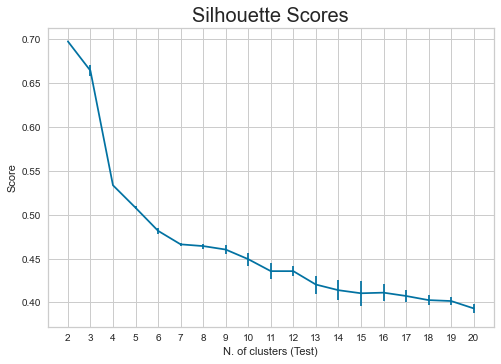

In [4]:
# Silhoutte Coef is used when the ground truth is not known
# Scores range from -1 to 1
# -1 being incorrect clustering
# 0 indicating overlapping
# 1 indicating highly dense clusters

generate_silhoutte_score_plot(X, 21, KMeans)

Figure 2 shows the silhoutte coefficient values for 2 clusters as well as a red line confirming the average silhoutte value of 0.7 shown earlier. Figure 3 shows that the clusters are very far from each other. One cluster is also significantly larger than the other cluster. The silhoutte score starts as we start to increase k past 2 clusters and overlapping between clusters is observed for k-values above 4. 

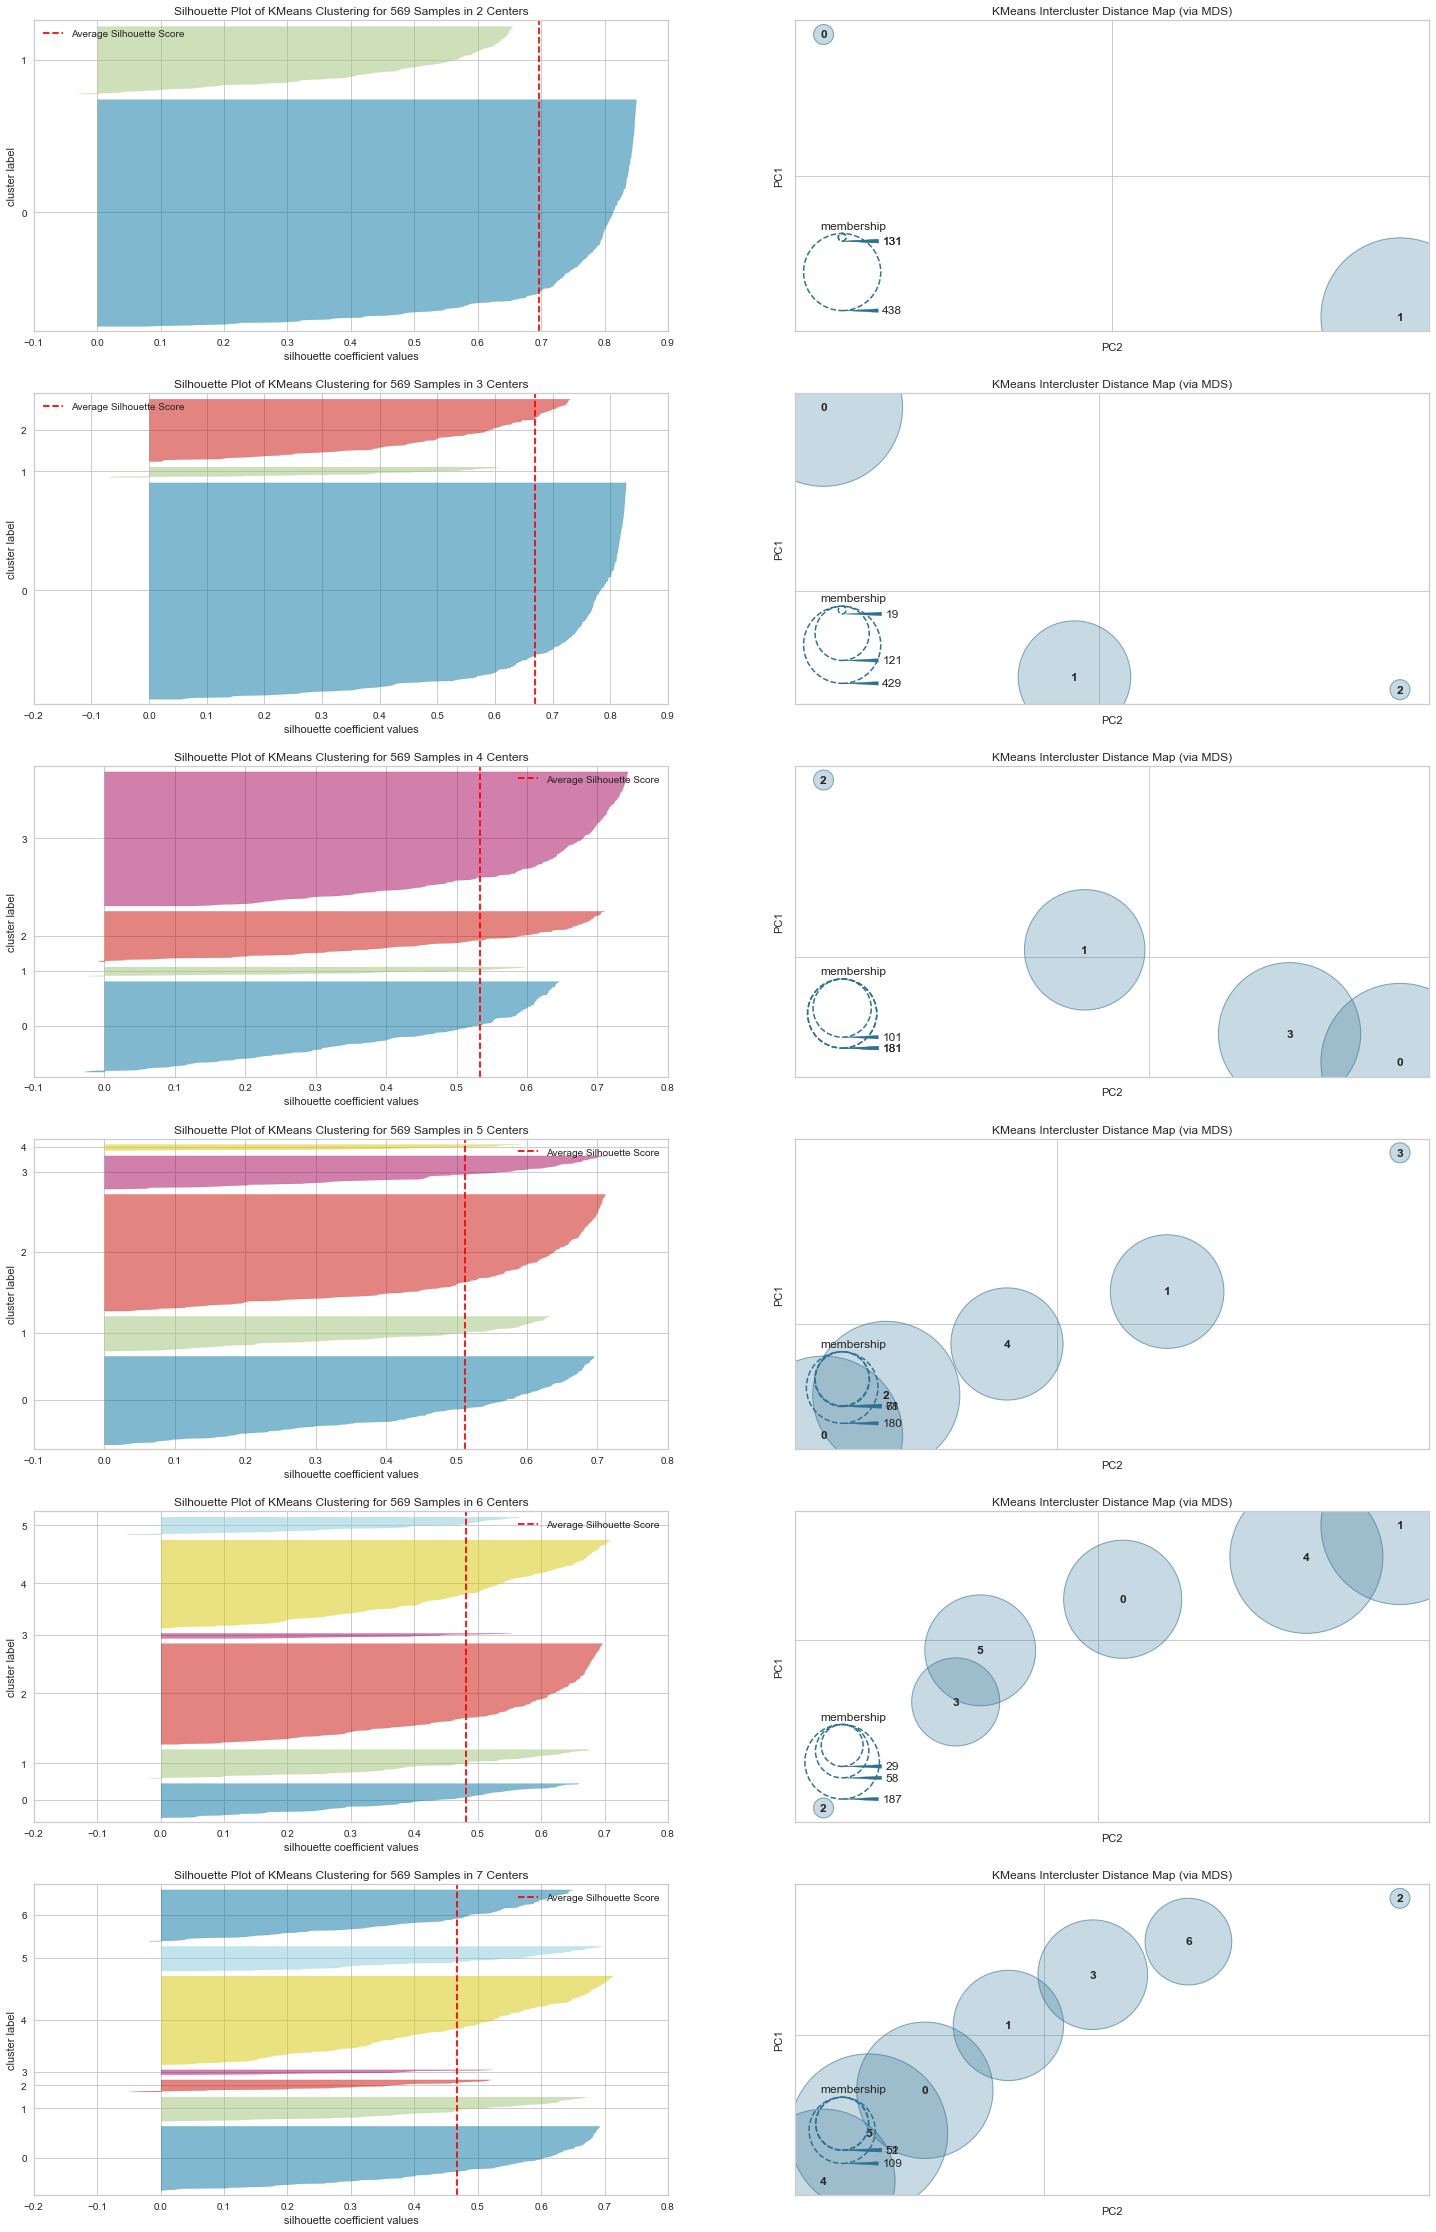

In [5]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(X, k)

## Expected Maximization

In [6]:
X, y = load_data('wdbc-modified.data')

I used the GaussianMixture model from SciKitLearn with the default settings to implement Expected Maximization. I tested the numbers 2 to 21 to find the optimal number of components. 

Figure 4 shows that 2 components produces the maximum silhoutte score, which is the same number of groupings as the KMeans implementation shown earlier except that it has a lower silhoutte score.

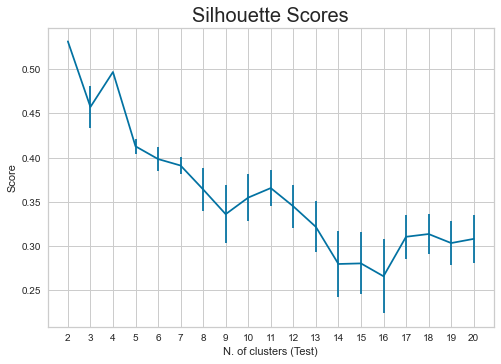

In [7]:
# generate_gmm_silhoutte_score_plot(X, 21)
generate_silhoutte_score_plot(X, 21, GaussianMixture)

Next I decided to calculate the distance between the Gaussian Mixture Models. This involves randomly generating two datasets then testing how similar the two models are with each other. The Jensen-Shannon metric is used to measure the distance between GMMs and what they say about the fit of the data. We see that the error increases when we go from 2 to 3 and that 2 components has the smallest Jensen-Shannon distance, so it is the ideal n-value for this problem set.

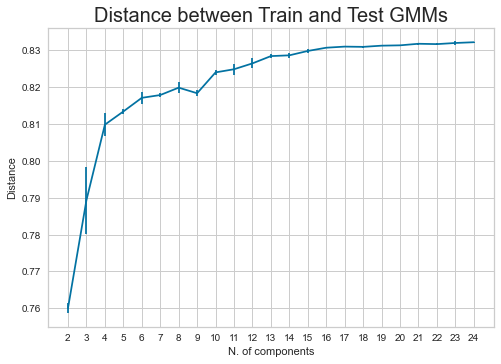

In [8]:
generate_distance_bw_gmms_plots(X, 25)

Here we see that 2 components has the lowest BIC (Bayesian Information Criterion) score, which shows that the model is able to predict our data and the underlying distribution. The amount of error is significant when k equals 6 or above. 

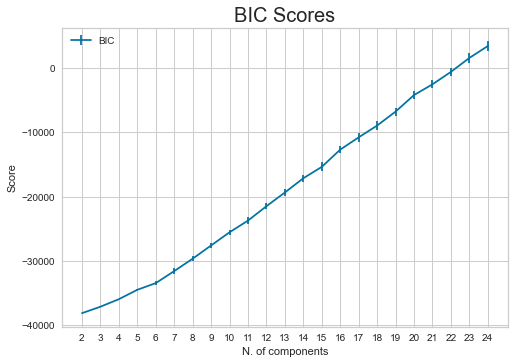

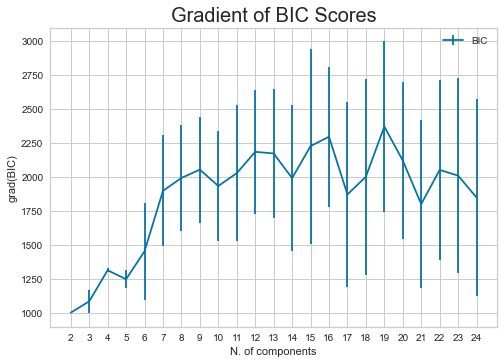

<Figure size 576x396 with 0 Axes>

In [9]:
generate_bic_plot(X, 25)

# Tic Tac Toe

IB3-CI is the first instance-based learning algorithm to show higher accuracies, lower storage
requirements, and the use of fewer attributes compared to previous instance-based learning algorithms [2].
The particular dataset used to showcase this algorithm was a tic-tac-toe dataset which included various
final states at the end of a game of tic-tac-toe [2].
This dataset was obtained from the UCI Machine Learning Repository. It includes 958 instances
each with 9 attributes. Each of these 9 attributes represents a single square on a 9-tile tic-tac-toe board at
the end of a single game. The possible values for each of these attributes is x (first player), o (empty), and
b (second player). The labels are balanced and can either be “positive” or “negative”, where a “positive”
represents a win for the first player (x). There was encoding applied to the dataset, such that x, o, and b
were replaced with 1, 0, and -1, respectively.

## KMeans 

In [34]:
X, y = load_data('tic-tac-toe-modified.data')

Figure shows a plot of the silhoutte scores for each k value from 2 to 21. Too few clusters and too many clusters result in a lower score. k=10 had the maximum silhoutte score of ~0.127, however this value had a very high error rate. k=8 seemed to be the next best option since it has close to the maximum silhoutte scores, which is just over 0.125. This value is still very low and indicates that there is overlapping between clusters. 

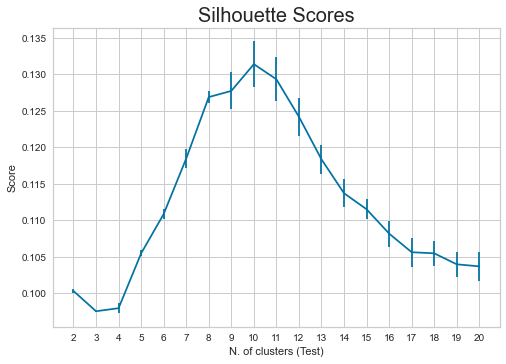

In [35]:
generate_silhoutte_score_plot(X, 21, KMeans)

Figure and figure show that there is indeed there is overlapping between several clusters. One would expect the ideal number of clusters to be 2 in the case of a tic tac toe game, where we have 9 features, each of which describes a square on the board and the overall state. It is also interesting to note that the ideal value for k, which is 8, is close to the number of features we have. These features also are restricted to values of -1, 0, and 1, which might make it more difficult to make distinct clusters

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


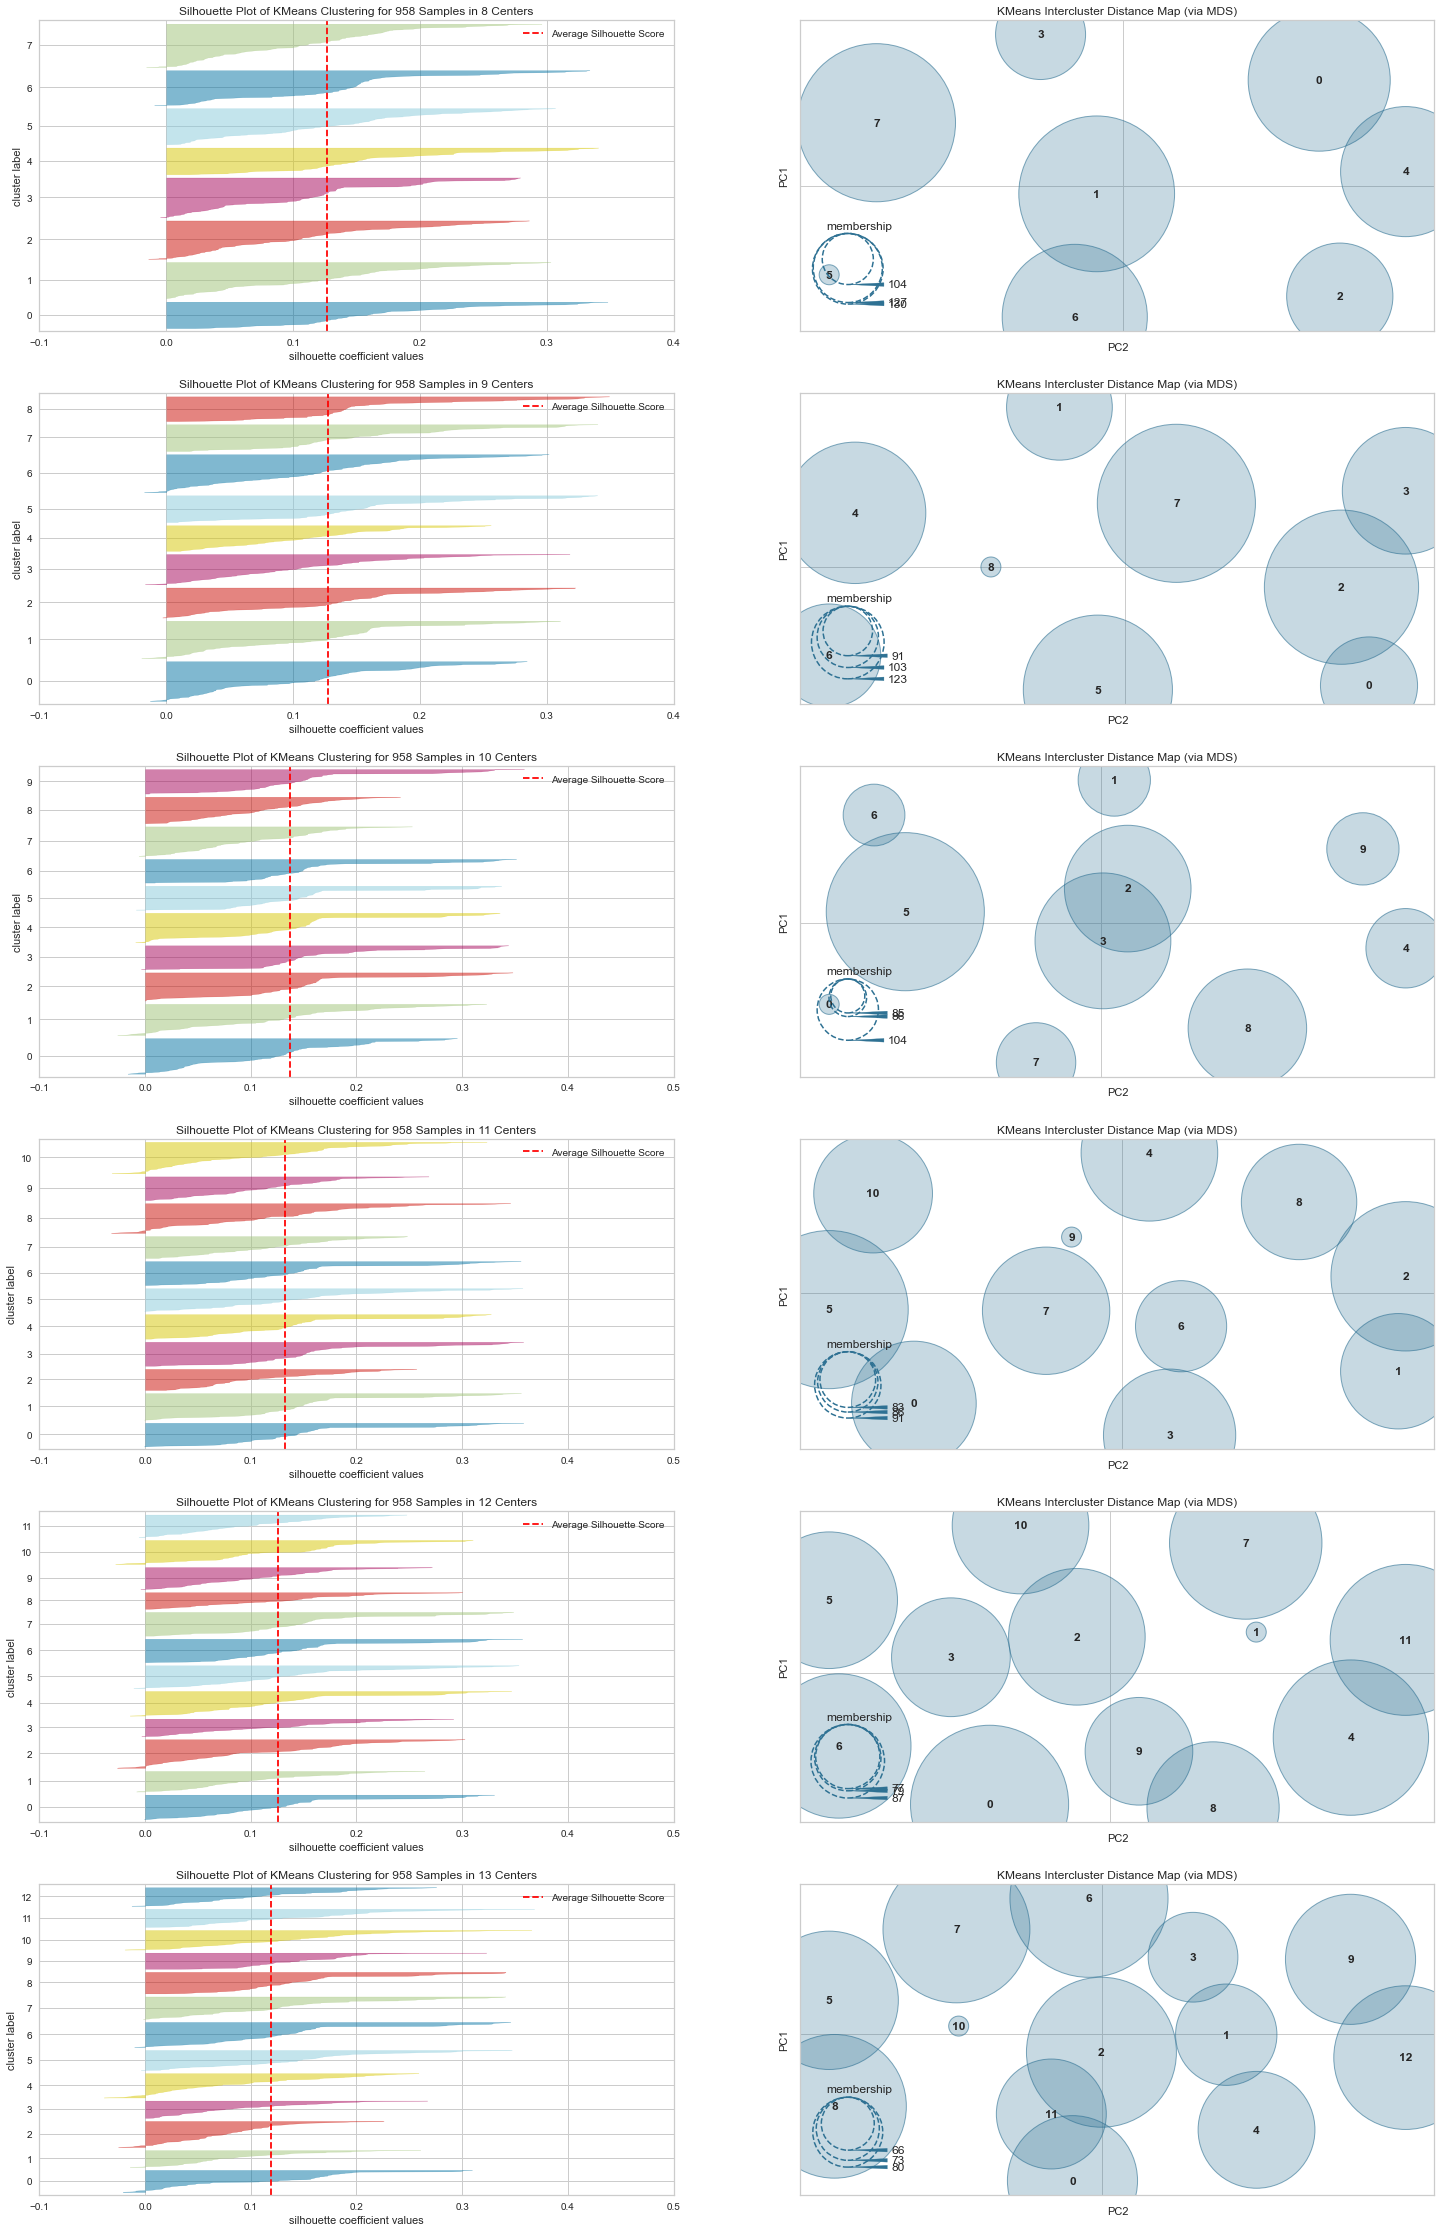

In [37]:
k = list(range(8,14))
generate_kmeans_SV_ICD_plots(X, k)

# Expected Maximization - Tic Tac Toe 

In [13]:
X, y = load_data('tic-tac-toe-modified.data')

Silhoutte score indicates 2 clusters, Distance indicates 3, 

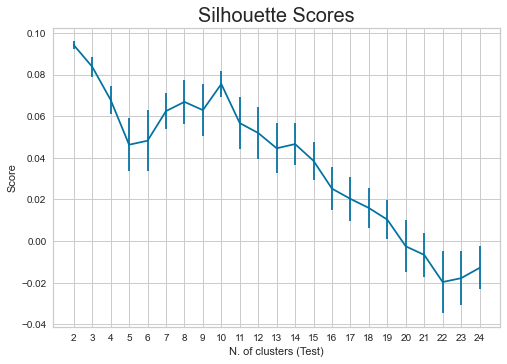

In [14]:
generate_silhoutte_score_plot(X, 25, GaussianMixture)

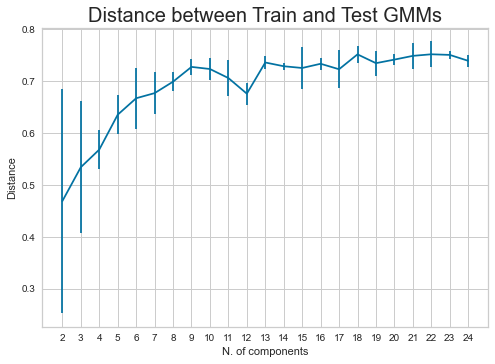

In [15]:
generate_distance_bw_gmms_plots(X, 25)

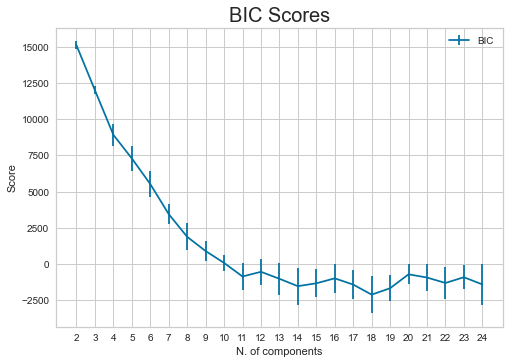

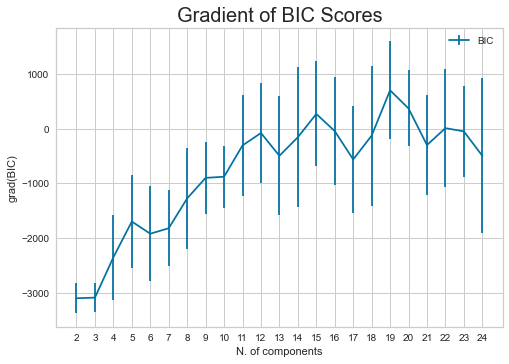

<Figure size 576x396 with 0 Axes>

In [16]:
generate_bic_plot(X, 25)

In [17]:
# KMeans BC Data, k = 2
# Expected Maximization BC Data, n = 2
# KMeans TTT Data, k = 8
# Expected Maximization TTT Data, n = 2

# Train and Query Times

## KMeans - Breast Cancer

In [38]:
X, y = load_data("wdbc-modified.data")
start = time.time()
kmeans=KMeans(2).fit(X)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
kmeans.predict(X)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.03939199447631836
Query time: 0.0009710788726806641


## Expected Maximization - Breast Cancer

In [39]:
X, y = load_data("wdbc-modified.data")
start = time.time()
gmm=GaussianMixture(2).fit(X)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.11268091201782227
Query time: 0.0007359981536865234


## KMeans - Tic Tac Toe 

In [40]:
X, y = load_data("tic-tac-toe-modified.data")
start = time.time()
kmeans=KMeans(8).fit(X)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
kmeans.predict(X)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.14501714706420898
Query time: 0.001068115234375


## Expected Maximization - Tic Tac Toe 

In [41]:
X, y = load_data("tic-tac-toe-modified.data")
start = time.time()
gmm=GaussianMixture(2).fit(X)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.020969867706298828
Query time: 0.0008399486541748047
